# ChiSquare Test:
This Python macro illustrates the use of ChiSquare as a goodness-of-fit measure,
how the ChiSquare distribution comes about, how to use the ChiSquare value (along with
number of degrees of freedom, Ndof) as a test, and that it actually works!

The program generates a certain number of datasets, each consisting of 9 points along
a line. These are then fitted, and the result and the Chi2 of the fit is recorded along
with the probability of the fit.

## References:
- Barlow: Chapter 6
- Cowan: Chapter 2.7, Chapter 7
- Bevington: Chapter 6

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   17th of November 2022

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

# Initial Question/Task:
Make sure you've read the relevant references and that you understand not only what the ChiSquare is, but also that its value follows the ChiSquare distribution, and that the probability of obtaining such a ChiSquare or worse (assuming that the hypothesis/PDF is the correct one!) can be calculated from it. Try to go to the "External Functions" and find the Chi2Regression function, and then read through the code to see, that it does as you would expect (note: It is essentially the last line, in which the Chi2 calculation is done).

Executive Summary: The ChiSquare method is used both for getting a good and robust fit, and for testing the quality/probability of this fit.

## Program settings:

In [3]:
r = np.random                         # Random generator
r.seed(1)                            # Set a random seed (but a fixed one - more on that later.)

Nexp = 1
save_plots = False

Parameters used in this problem (constant, linear coef., quadratic coef., and uncertainty in y) for generating a line (parabola) with N points and given uncertainty on points:

In [4]:
Npoints = 9
alpha0 = 3.6
alpha1 = 0.3
alpha2 = 0.0     # Initially, we don't include a quadratic term!
sigmay = 1.0     # The uncertainty on each point is set to 1.0

# Generating and fitting data:
In the following, we generate data points following a simple line. The linear fit (and a few other simple ones) can be done analytically, as discussed in Barlow chapter 6.2 and outlined here: http://www.nbi.dk/~petersen/Teaching/Stat2021/Notes/StraightLineFit.pdf .
The numerical fit of the line (and any other function) is done iteratively by Minuit. The code is slightly shorter, but a lot slower, as the code will typically test many (50-500) possible combination of fit parameters, before it finds the best values for the fitting parameters. However, with fast computers, we don't care too much!

The whole thing is contained in a loop, allowing us to repeat the generation and fitting, so that we can see the result on more than just a case-by-case. For this reason, we save the result of the fit (in pre-defined arrays). In real life you would typically simply do one fit, and then know and trust the conclusions from this exercise.

In [5]:
Minuit.print_level = 0      # Don't print the fit result (many fits to do!)

# Arrays for storing fit results:
array_alpha0 = np.zeros(Nexp)
array_alpha1 = np.zeros(Nexp)
array_Chi2 = np.zeros(Nexp)
array_Prob = np.zeros(Nexp)

# Loop, repeating the data generation and fit:
for iexp in range(Nexp) : 

    # Generate data:
    # ------------------------------------------------------------------ #
    # Fill values into (x,y) and associated uncertainties (here chosen to be 0 for x):
    x = np.arange(Npoints)+1
    ex = np.zeros_like(x)
    y = alpha0 + alpha1*x + r.normal(0, sigmay, Npoints) + alpha2*x**2
    # Note how we include uncertainty in y - by simply adding a Guassian number to the "theoretical value".
    ey = sigmay*np.ones_like(x)


    # Fit the data:
    # ------------------------------------------------------------------ #
    # Define a fit function:
    def fit_function(x, alpha0, alpha1):
        return alpha0 + alpha1*x

    # Now we define a ChiSquare to be minimised (using ExternalFunctions):
    chi2_object = Chi2Regression(fit_function, x, y, ey)
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    # Alternatively, you can define Chi2 calculation:
    def chi2_owncalc(alpha0, alpha1) :
        y_fit = fit_function(x, alpha0, alpha1)
        chi2 = np.sum(((y - y_fit) / ey)**2)
        return chi2
    chi2_owncalc.errordef = 1.0    # Chi2 definition (for Minuit)
    
    # Here we let Minuit know, what to minimise, how, and with what starting parameters:   
    # minuit = Minuit(chi2_object, alpha0=3.0, alpha1=0.0)     # External Functions
    minuit = Minuit(chi2_owncalc, alpha0=3.0, alpha1=0.0)     # Own alternative

    # Perform the actual fit:
    minuit.migrad();
    
    # Extract the fitting parameters and their errors:
    alpha0_fit = minuit.values['alpha0']
    alpha1_fit = minuit.values['alpha1']
    sigma_alpha0_fit = minuit.errors['alpha0']
    sigma_alpha1_fit = minuit.errors['alpha1']
    
    Nvar = 2                     # Number of variables (alpha0 and alpha1)
    Ndof_fit = Npoints - Nvar    # Number of degrees of freedom = Number of data points - Number of variables
    
    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    
    # Fill the arrays with fit results (to produce plots of these at the end):
    array_alpha0[iexp] = alpha0_fit
    array_alpha1[iexp] = alpha1_fit
    array_Chi2[iexp] = Chi2_fit
    array_Prob[iexp] = Prob_fit
    
    # Let us see what the fit gives for the first couple of data sets:
    if (iexp < 10) :
        print(f"  Fit: a0={alpha0_fit:6.3f}+-{sigma_alpha0_fit:5.3f}  a1={alpha1_fit:5.3f}+-{sigma_alpha1_fit:5.3f}  p={Prob_fit:6.4f}")


  Fit: a0= 3.716+-0.726  a1=0.261+-0.129  p=0.0500


# Plot an example result:
Below we plot the latest fit (i.e. the last one from above), so that we can actually see what is going on (and potentially wrong!).

Your job from here is to first inspect a single fit, i.e. both parameters, their uncertainties, the Chi2 value, and the resulting probability. Having done that, you should then inspect the distribution of these, having repeated the fit many times with new random data sets... and see the patterns in this.

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(x, y, ey, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x, fit_function(x, *minuit.values[:]), '-r')     # Note how we can "smartly" input the fit values!
plt.close()

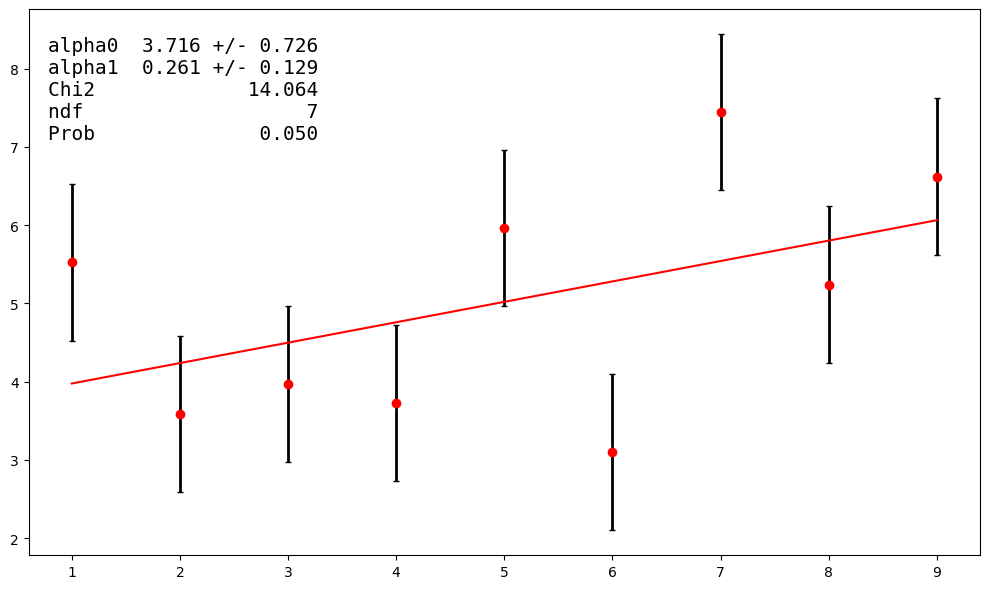

In [7]:
d = {'alpha0':   [alpha0_fit, sigma_alpha0_fit],
     'alpha1':   [alpha1_fit, sigma_alpha1_fit],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=14)
fig.tight_layout()
if (save_plots) :
    fig.savefig("FitToLine.pdf")
fig

# Considering many experiments
In case we have more than one "experiment" (i.e. fit), we would like to see how the fit results and the Chi2 values distribute themselves:

In [8]:
if (Nexp > 1) :
    
    fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
    ax2 = ax2.flatten()

    # Distribution of alpha0 values:

    # Distribution of alpha1 values:
    
    # Distribution (normed) of Chi2 values, along with Chi2-distribution (for Ndof=7) drawn on top:
    
    # Distribution of Chi2 fit probabilities:
    
    
    plt.tight_layout()
    if (save_plots) :
        fig2.savefig('FitResultDistributions.pdf')

# Remark on $\chi^2$ rule of thumb:
A general rule is that the "reduced chisquare" (defined as $\chi^2$/Ndof) should be "around 1". That is true, but the rule definitely has its limitations, since "around" depends on the size of Ndof! This is examplified below, considering two cases with the same reduced chisquare of 1.5, but with **very** different conclusions.

The reason for this can be found in the mean and width of the $\chi^2$ distribution (with Ndof = k), which are k and sqrt(2k). From the central limit theorem, the $\chi^2$ should approach a Gaussian for "large" values of k (k > 50 is probably enough), but the **relative** width (i.e. width/mean) becomes smaller and smaller as k grows, and a reduced chisquare of e.g. 1.5 becomes more and more unlikely, as k increases.

In [9]:
# Numbers to illustrate the point, that using the ratio Chi2/Ndof ("reduced chisquare") is only a rule of thumb:
print("\n  Considering the relation between Chi2/Ndof ratio and Prob(Chi2,Ndof) vs. Ndof:")
print("  Low number of degrees of freedom:   Prob(  3.0,  2) = %9.7f"%(stats.chi2.sf(  3.0,   2)))
print("  High number of degrees of freedom:  Prob(300.0,200) = %9.7f"%(stats.chi2.sf(300.0, 200)))


  Considering the relation between Chi2/Ndof ratio and Prob(Chi2,Ndof) vs. Ndof:
  Low number of degrees of freedom:   Prob(  3.0,  2) = 0.2231302
  High number of degrees of freedom:  Prob(300.0,200) = 0.0000059


The conclusion is, that while the reduced $\chi^2$ is a good rule of thumb, it is NOT the correct way to consider a $\chi^2$ value.

---



# Questions:

 1) Run the code such that it does exactly one fit (initial setting), and take a look at the line fitted.
    Does this look reasonable, and are you satisfied with the fit probability? Does the fit reproduce the input
    numbers well (include the uncertainties in your consideration)?

 2) What is the chance that the input for the data could actually be from a flat distribution, i.e. without the slope?<br>
    (There is a correct (slower) way of doing this, and another quick but approximate way of testing this).

 3) Now increase the number of experiments to e.g. 1000, and rerun the macro. Figure
    out what you see in the window split in 2-by-2, and go through each of these to
    see, if you understand every feature of the distributions shown, and if you are
    happy with them! Is this what you expected? Are they also as wide as you would expect?<br>
    This somehow makes for a "long" question without any leading questions.
    But this is what data analysis is usually about, and you should try to be statistically minded
    and have an idea of what to look for, at least to some degree. We will discuss this further in class.

 4) Investigate if the distributions of probabilities is flat, or if it has some
    slope to it. Do you understand why the distributions of probabilities is flat?<br>
    (This is typically conceptually hard to begin with, but don't worry!)

 5) Find the line of code where the random points for the line are generated, and add a
    quadratic term in x with the coefficient alpha2 = -0.04. Run the program again with Nexp=1,
    and start by looking at the single fit in the graph. Can you see this change?
    Now run 1000 experiments again, and see what has changed in the distributions
    in the 2-by-2 window when including such a term. Are these changes as you would
    have expected them?
    <br>
    NOTE: The reason why the quadratic term is more clear in the latter case is NOT
    that it is a better method. It is simply because there is 1000 times more statistics!

 6) With the quadratic coefficient from question 5), the linear fit of course does
    not do very well. What changes are needed for the fit to be good again? Make
    these changes, and see that the condition in question 4) is again met.

### (Semi-)Advanced questions:

 7) Try to generate data according to more advanced functions, and then fit the data with these.
    Do you still obtain a flat distribution in probability? Do you also manage to fit these with
    simpler/other functions and still maintain the flat distribution?
    Alternatively, consider the other Chi2 exercise with several functions.


# Learning points:

The ChiSquare plays a central role in this course, as it is a simple and very useful way of fitting data.

From this exercise you should have learned that:
1. The ChiSquare formula, and that it is a quantity that we use for optimising, e.g. fitting.
2. A weighted mean is identical to a ChiSquare fit with a constant.
3. If uncertainties are Gaussian, the ChiSquare is identical to the (optimal) likelihood.
4. The ChiSquare provides a measure-of-goodness, that is a way to quantify, if a fit resembles data or not.
5. The number of degrees of freedom (Ndof) in a fit is the number of values fitted minus the number of parameters in the fit.
6. Using the ChiSquare value divided by Ndof is **only a rule of thumb** and not accurate.
7. The ChiSquare p-value gives: _"the probability of obtaining a higher (i.e. worse) ChiSquare value, provided that the fit function correctly describes the data"_.

The concepts of p-value, likelihood, and hypothesis testing are to come.